<a href="https://colab.research.google.com/github/ujjawalsingh10/Human-Emotions-Detection/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, RandomContrast,  Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install -q kaggle

In [ ]:
#! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
#!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

In [ ]:
#!unzip '/content/human-emotions-datasethes.zip' -d '/content/drive/MyDrive/Deep_Learning/Human_Emotions_Detection/dataset/'

In [ ]:
train_directory = '/content/drive/MyDrive/Deep_Learning/Human_Emotions_Detection/dataset/Emotions Dataset/Emotions Dataset/train'
val_directory = '/content/drive/MyDrive/Deep_Learning/Human_Emotions_Detection/dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'sad'] ##Should match with the name of the directories

CONFIGURATION = {
    'BATCH_SIZE' : 32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 100,
    'N_DENSE_2': 10,
    'NUM_CLASSES': 3
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)


Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)


Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

### Data Visualization

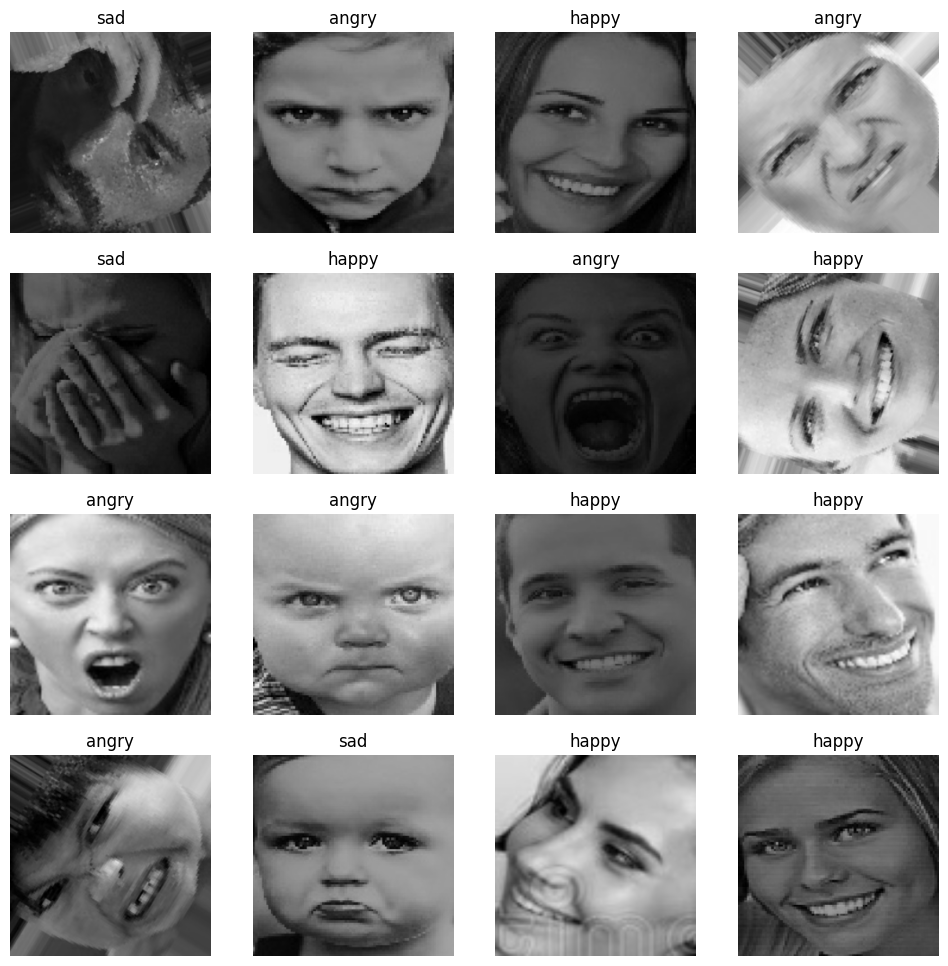

In [ ]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]) ## Cuz our labels were one hot representations
    plt.axis('off')

## Data Augmentation

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025),), ## Keeping the rotation to a understandable angels not upside downs
    RandomFlip(mode = 'horizontal', ),
    RandomContrast(factor = 0.1)
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

### Cutmix Data Augmentation

In [30]:


def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w



In [31]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

### Data Preparation

In [32]:
# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [33]:
# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [46]:
training_dataset = (train_dataset
                    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE)
                    )

In [47]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
    )

In [36]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

## TFRecords
We unbatch our data...if there's been batching done to proceed with tfrecords

In [34]:
training_dataset = (train_dataset
                    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
                    #.prefetch(tf.data.AUTOTUNE)
                    )

In [35]:
validation_dataset = (
    val_dataset
    #.prefetch(tf.data.AUTOTUNE)
    )

In [37]:
training_dataset = (
    training_dataset.unbatch()
)

In [38]:
validation_dataset = (
    validation_dataset.unbatch()
)

In [39]:
training_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [40]:
### Feature documentation in tensorflow
### The label is the int feature and byte is the image feature
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [41]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord' ## TO create diff shard/ with diff file names /blocks for data

In [42]:
## To convert tensor images to bytes
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [43]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

In [45]:
## tfrecords documentation tensorflow
for shard_number in range(NUM_SHARDS):

  #We create a shard dataset (tf.dataset documentation) with num_shards and index
  shard_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    ## tfrecords documentation we already did in the above fucntion

    for encoded_image, encoded_label in shard_dataset:
      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)


KeyboardInterrupt: ignored

In [ ]:
##Getting the list of tfrecods
#l = [PATH.format(p) for p in range(NUM_SHARDS)]
#print(l)

In [ ]:
## To get the reconstructed dataset we are gonna pass the tfrecords into tfrecodsdataset
recons_dataset = tf.data.TFRecordDataset(filenames = [PATH.format(p) for p in range(NUM_SHARDS)])

In [ ]:
## Parse the tfrecord dataset to get the original..images and labels
def parse_tfrecords(example):

  feature_description = {
      'images': tf.io.FixedLenFeature([], tf.string),
      'labels': tf.io.FixedLenFeature([], tf.int64),
  }
  example = tf.io.parse_single_example(example, feature_description)
  ## Convert from byte to uint
  example['images'] = tf.io.decode_jpeg(example['images'], channels = 3)

  return example['images'], example['labels']


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION['BATCH_SIZE'])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

## Modelling

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,
    Conv2D(filters = CONFIGURATION['N_FILTERS'] , kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'] , padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION['POOL_SIZE'], strides= CONFIGURATION['N_STRIDES']*2),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE'] ),

    Conv2D(filters = CONFIGURATION['N_FILTERS']*2 + 4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION['POOL_SIZE'], strides= CONFIGURATION['N_STRIDES']*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(CONFIGURATION['NUM_CLASSES'], activation = "softmax"),

])

lenet_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## Training

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k=2, name = 'top_k_accuracy')]

In [ ]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 35s 146ms/step - loss: 0.9191 - accuracy: 0.5799 - top_k_accuracy: 0.8322 - val_loss: 1.1480 - val_accuracy: 0.3586 - val_top_k_accuracy: 0.7695
Epoch 2/20
213/213 [==============================] - 24s 110ms/step - loss: 0.6636 - accuracy: 0.7226 - top_k_accuracy: 0.9140 - val_loss: 1.2353 - val_accuracy: 0.4982 - val_top_k_accuracy: 0.7761
Epoch 3/20
213/213 [==============================] - 28s 130ms/step - loss: 0.4856 - accuracy: 0.8122 - top_k_accuracy: 0.9546 - val_loss: 0.8005 - val_accuracy: 0.6782 - val_top_k_accuracy: 0.8911
Epoch 4/20
213/213 [==============================] - 24s 113ms/step - loss: 0.2932 - accuracy: 0.9009 - top_k_accuracy: 0.9797 - val_loss: 0.8413 - val_accuracy: 0.6918 - val_top_k_accuracy: 0.8806
Epoch 5/20
213/213 [==============================] - 23s 106ms/step - loss: 0.2106 - accuracy: 0.9298 - top_k_accuracy: 0.9879 - val_loss: 1.2089 - val_accuracy: 0.5909 - val_top_k_accuracy: 0.8573
Epoch

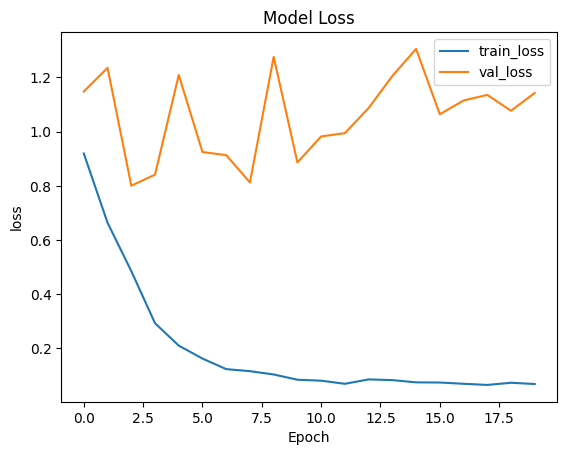

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

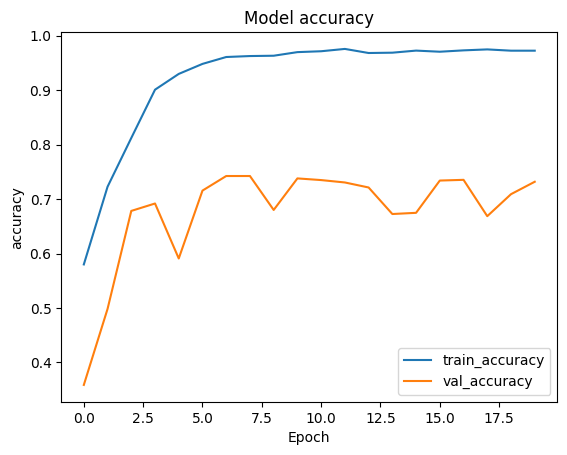

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Evaluation

In [ ]:
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 6s 69ms/step - loss: 1.1426 - accuracy: 0.7318 - top_k_accuracy: 0.8964


[1.1425765752792358, 0.7317822575569153, 0.8964003324508667]

## Testing


In [ ]:
test_image = cv2.imread('/content/drive/MyDrive/Deep_Learning/Human_Emotions_Detection/dataset/EmotionsDataset_Splitted/data/test/sad/102.jpg')

im = tf.constant(test_image, dtype = tf.float32)

##adding the batch dimension
im = tf.expand_dims(im, axis  = 0)

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

sad


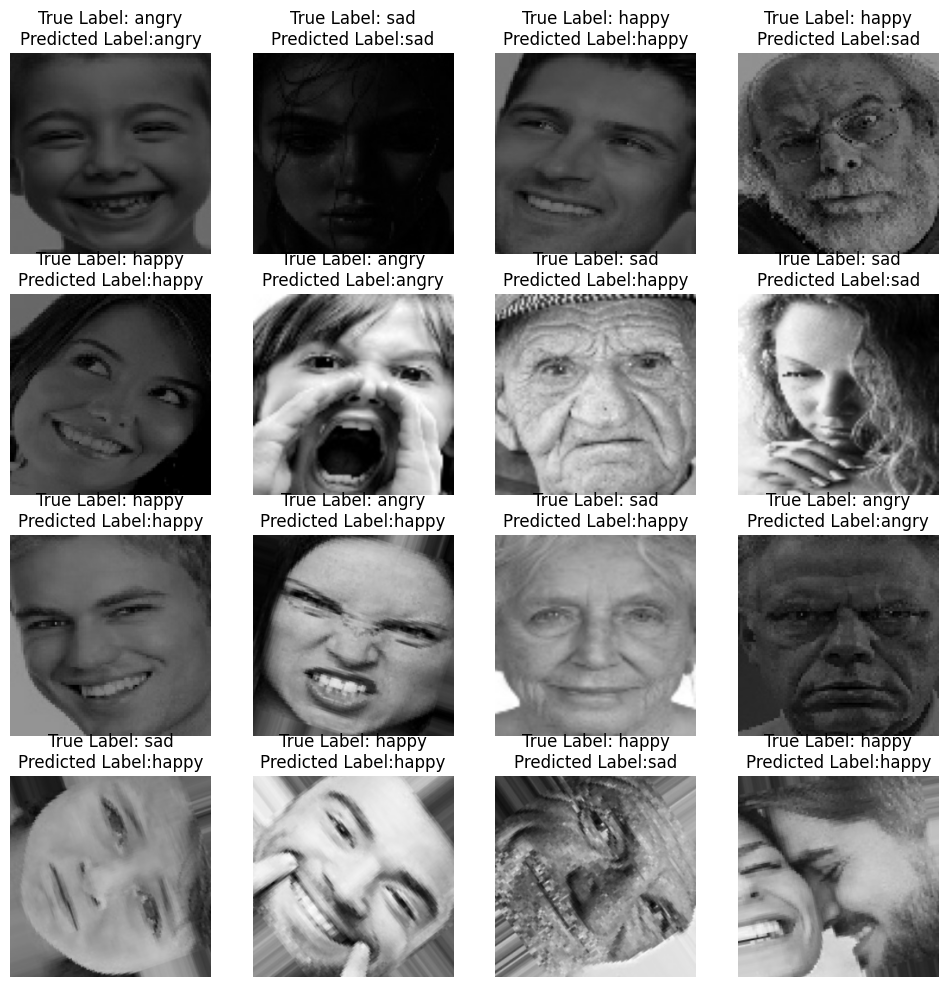

In [ ]:
plt.figure(figsize = (12, 12))
for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255)
    plt.title("True Label: " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted Label:" + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]])
    plt.axis('off')

## Confusion Matrix

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
## We get softmax 3 output values from model inference..we get single value o/p with argmax and get it in a single list with flatten
## We first take all the batches except the uneven last one...then concat it with the last remaining ones
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 1 ... 0 0 1]
[1 1 2 ... 0 0 1]


In [ ]:
pred = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

[[296  37  58]
 [ 94 803 131]
 [125 166 568]]


Text(0.5, 58.7222222222222, 'Predicted')

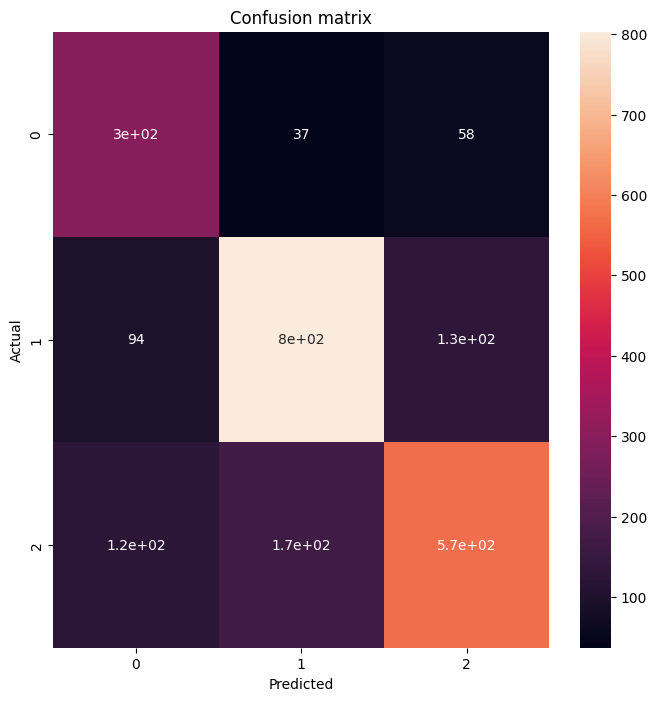

In [ ]:
# threshold = 0.5
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True##)
plt.title(f'Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')